# Physical origin of the momentum broadening anisotropy in the Glasma

In this notebook we investigate the physical origin of the momentum broadening anisotropy closer using the weak field limit. We specifically study the two-dimensional dilute Glasma without longitudinal expansion, in order to get a cleaner separation of effects. Recall from section A of **arXiv:2001.10001**, that the field strengths in the dilute Glasma evolve according to

\begin{align}
E_z(\tau, \mathbf x) &= + \intop_k J_0(k \tau) \tilde{E}_z(0, \mathbf k) e^{i \mathbf k \cdot x}, &\qquad B_z(\tau, \mathbf x) &= + \intop_k J_0(k \tau) \tilde{B}_z(0, \mathbf k) e^{i \mathbf k \cdot x}, \\
E_y(\tau, \mathbf x) &= - \intop_k \frac{i k_x}{k} J_1(k \tau) \tilde{E}_z(0, \mathbf k) e^{i \mathbf k \cdot x}, &\qquad B_y(\tau, \mathbf x) &= + \intop_k \frac{i k_x}{k} J_1(k \tau) \tilde{B}_z(0, \mathbf k) e^{i \mathbf k \cdot x},
\end{align}

where $k = |\mathbf k|$. Expressions for $E_x$ and $B_x$ are analogous. These are solutions to the linearized Yang-Mills equations in a longitudinally expanding background

\begin{align}
P^i &= \tau \partial_\tau A_i, &\qquad P^\eta &= \frac{1}{\tau} \partial_\tau A_\eta, \\
\partial_\tau P^i &= \tau \partial_j F_{ji}, &\qquad \partial_\tau P^i\eta &= \frac{1}{\tau} \Delta A_i.
\end{align}

These are the expressions that we used to derive our dilute Glasma results. We obtain the non-expanding versions of the equations by omitting all explicitly $\tau$-dependent terms.

\begin{align}
P^i &=  \partial_\tau A_i, &\qquad P^\eta &= \partial_\tau A_\eta, \\
\partial_\tau P^i &= \partial_j F_{ji}, &\qquad \partial_\tau P^i\eta &= \Delta A_i.
\end{align}

The analogous field strength solutions are

\begin{align}
E_z(\tau, \mathbf x) &= + \intop_k \cos(k \tau) \tilde{E}_z(0, \mathbf k) e^{i \mathbf k \cdot x}, &\qquad B_z(\tau, \mathbf x) &= + \intop_k \cos(k \tau) \tilde{B}_z(0, \mathbf k) e^{i \mathbf k \cdot x}, \\
E_y(\tau, \mathbf x) &= - \intop_k \frac{i k_x}{k} \sin(k \tau) \tilde{E}_z(0, \mathbf k) e^{i \mathbf k \cdot x}, &\qquad B_y(\tau, \mathbf x) &= + \intop_k \frac{i k_x}{k} \sin(k \tau) \tilde{B}_z(0, \mathbf k) e^{i \mathbf k \cdot x},
\end{align}

The force acting on the moving test particle is given by

\begin{align}
f^y(\tau) = E_y(\tau) - B_z(\tau), \qquad f^z(\tau) = E_z(\tau) + B_y(\tau),
\end{align}

where the field strengths are evaluated along the trajectory of the particle $x(\tau) = \tau$. Inserting the fields yields

\begin{align}
f^y(\tau) = - \intop_k \gamma(\tau, \mathbf k) \tilde{B}_z(0, \mathbf k), \qquad 
f^z(\tau) = + \intop_k \gamma(\tau, \mathbf k) \tilde{E}_z(0, \mathbf k),
\end{align}
where

$$
\gamma(\tau, \mathbf k) = \big( \frac{i k_x}{k} \sin( k \tau) + \cos(k \tau) \big) e^{i k_x \tau}.
$$

Following the same steps as in  **arXiv:2001.10001**, the accumulated momenta are given by

$$
\big< p^2_{(y, z)}(\tau) \big>_R = Q^4 \frac{T_R D_F D_A}{D_R} \intop_k G(\tau, \mathbf k) c_{(B,E)}(\mathbf k, m),
$$

where $Q = g^2 \mu$ and $c_{(B,E)}(\mathbf k, m)$ are the Fourier representations of the initial magnetic and electric field correlators. For quarks the color-dependent factor evaluates to

$$
\frac{T_R D_F D_A}{D_R} = \frac{(N^2_c - 1)}{2}.
$$

The function $G(\tau, \mathbf k)$ is given by

$$
G(\tau, \mathbf k) = \big| \intop^\tau_0 d\tau' \gamma(\tau', \mathbf k) \big|^2.
$$

In the case of a non-expanding evolving Glasma this evaluates to

$$
G(\tau, \mathbf k) = \frac{\sin(k \tau)^2}{k^2}.
$$

We want to compare this to the case of a static Glasma, where the initial flux tubes are frozen in place at $\tau = 0$, while the test particle passes through the Glasma. This can be achieved by setting $\tau = 0$ in the terms of $\gamma$ that originate from the field strength solutions. We find

\begin{align}
\gamma(\tau, \mathbf k) &= e^{i k_x \tau}, \\
G(\tau, \mathbf k) &= \frac{4 \sin{(k_x \tau /2)^2}}{k_x^2}.
\end{align}

Having found the expressions for $G$ the only remaining task is to insert them into the definitions of the accumulated momenta and perform the integrals numerically. The initial field correlators $c_E$ and $c_B$ have closed form expressions that can be computed using Mathematica.

In [1]:
"""
    Import all kinds of modules
"""

from scipy.integrate import nquad, trapz, simps, quad
from numba import njit, jit, complex128, float32, float64, vectorize, njit
from numba.extending import get_cython_function_address
import ctypes
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


"""
    Initial field correlaotrs
"""

# Exact integrals from Mathematica
@vectorize('float64(float64)')
def cE(k):
    return (-2*(1 + 4/k**4 + 2/k**2)*np.sqrt(1 + 4/k**2) - 2*(1 + 8/k**6 + 16/k**4 + 6/k**2)*np.log(1/k) +
          (1 + 8/k**6 + 16/k**4 + 6/k**2) * np.log(((1 + np.sqrt(1 + 4/k**2) + 
        (2*(2 + np.sqrt(1 + 4/k**2) + k**(-2)))/k**2)*k**2)/2.))/(8.*(1 + 4/k**2)**2.5*k**2*np.pi)

@vectorize('float64(float64)')
def cB(k):
    return (-2*np.sqrt(1 + 4/k**2) - 2*(1 + 2/k**2)*np.log(1/k) + (1 + 2/k**2)*np.log(((1 + np.sqrt(1 + 4/k**2) + 
         (2*(2 + np.sqrt(1 + 4/k**2) + k**(-2)))/k**2)*k**2)/2.))/(8.*(1 + 4/k**2)**1.5*k**2*np.pi)

"""
    Evolution functions before theta integration
"""

@vectorize('float64(float64, float64)')
def G_evo(t, k):
    return (np.sin(k * t) / k) ** 2

@vectorize('float64(float64, float64, float64)')
def G_sta(t, k, th):
    kx = k * np.cos(th)
    return (2 - 2 * np.cos(kx * t)) / kx ** 2

"""
    Special functions
"""

# since numba does not support scipy.special out of the box, we have to do this:

# J(0,x)
addr = get_cython_function_address("scipy.special.cython_special", "j0")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j0_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j0(x):
    return j0_fn(x)

# J(1, x)
addr = get_cython_function_address("scipy.special.cython_special", "j1")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j1_fn = functype(addr)

@vectorize('float64(float64)')
def vec_j1(x):
    return j1_fn(x)

# H(n, x)
addr = get_cython_function_address("scipy.special.cython_special", "struve")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double, ctypes.c_double)
struve_fn = functype(addr)

@vectorize('float64(float64, float64)')
def vec_struve(n, x):
    return struve_fn(n, x)

"""
    Evolution functions after theta integration
"""

@vectorize('float64(float64, float64)')
def G_evo_int(t, k):
    return G_evo(t, k)

@vectorize('float64(float64, float64)')
def G_sta_int(t, k):
    kt = k * t
    a = vec_j1(kt) * (-2 + kt * np.pi * vec_struve(0, kt)) / k
    b = t * vec_j0(kt) * (2 - np.pi * vec_struve(1, kt))
    return t * (a + b)

"""
    Integrand for py and pz integrals
"""

def py_evo_integrand(k, t):
    return k * G_evo_int(t, k) * cB(k)

def pz_evo_integrand(k, t):
    return k * G_evo_int(t, k) * cE(k)

def py_sta_integrand(k, t):
    return k * G_sta_int(t, k) * cB(k)

def pz_sta_integrand(k, t):
    return k * G_sta_int(t, k) * cE(k)

"""
    Integration options
"""

subdivisions = 500

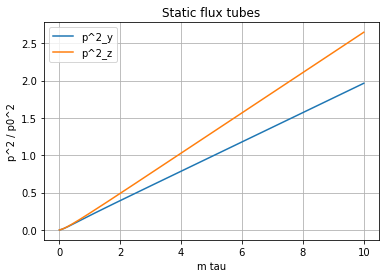

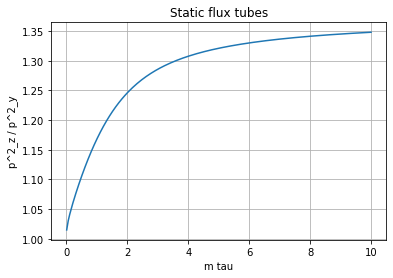

In [2]:
# static results
t_range = np.linspace(0.01, 10.0, num=200)

pys = []
pzs = []
for it, t in enumerate(t_range):
    py = quad(py_sta_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pz = quad(pz_sta_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pys.append(py)
    pzs.append(pz)
pys, pzs = np.array(pys), np.array(pzs)

plt.title("Static flux tubes")
plt.plot(t_range, pys, label="p^2_y")
plt.plot(t_range, pzs, label="p^2_z")
plt.grid()
plt.legend()
plt.xlabel("m tau")
plt.ylabel("p^2 / p0^2")
plt.show()
plt.title("Static flux tubes")
plt.plot(t_range, pzs / pys)
plt.grid()
plt.xlabel("m tau")
plt.ylabel("p^2_z / p^2_y")
plt.show()

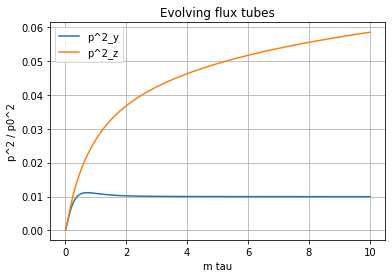

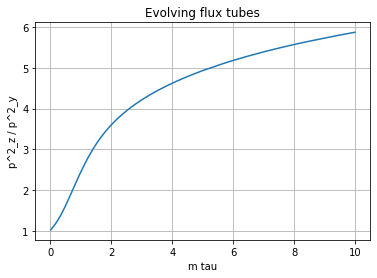

In [3]:
# evolving results
t_range = np.linspace(0.01, 10.0, num=200)

pys = []
pzs = []
for it, t in enumerate(t_range):
    py = quad(py_evo_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pz = quad(pz_evo_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pys.append(py)
    pzs.append(pz)
pys, pzs = np.array(pys), np.array(pzs)

plt.title("Evolving flux tubes")
plt.plot(t_range, pys, label="p^2_y")
plt.plot(t_range, pzs, label="p^2_z")
plt.grid()
plt.legend()
plt.xlabel("m tau")
plt.ylabel("p^2 / p0^2")
plt.show()
plt.title("Evolving flux tubes")
plt.plot(t_range, pzs / pys)
plt.grid()
plt.xlabel("m tau")
plt.ylabel("p^2_z / p^2_y")
plt.show()

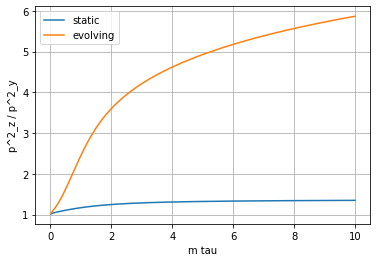

In [4]:
t_range = np.linspace(0.01, 10.0, num=200)

# static
pys = []
pzs = []
for it, t in enumerate(t_range):
    py = quad(py_sta_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pz = quad(pz_sta_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pys.append(py)
    pzs.append(pz)
pys, pzs = np.array(pys), np.array(pzs)

plt.plot(t_range, pzs / pys, label="static")

# evolving
pys = []
pzs = []
for it, t in enumerate(t_range):
    py = quad(py_evo_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pz = quad(pz_evo_integrand, 0, np.inf, (t), limit=subdivisions)[0]
    pys.append(py)
    pzs.append(pz)
pys, pzs = np.array(pys), np.array(pzs)

plt.plot(t_range, pzs / pys, label="evolving")

plt.grid()
plt.xlabel("m tau")
plt.ylabel("p^2_z / p^2_y")
plt.legend()
plt.show()

From these results it is clear that the momentum broadening anisotropy is more pronounced in the case of expanding flux tubes. This means that the main effect causing the anisotropy is due to particles moving with the wavefronts of expanding flux tubes. Let's look at the integrals in more detail now.

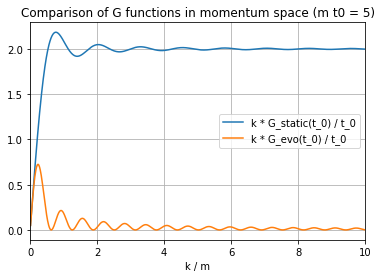

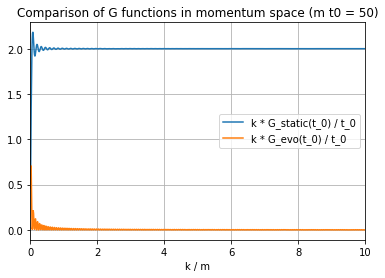

In [5]:
t0 = 5
k_range = np.linspace(0.01, 10.0, num=1000)

plt.title("Comparison of G functions in momentum space (m t0 = {})".format(t0))
plt.plot(k_range, k_range * G_sta_int(t0, k_range) / t0, label="k * G_static(t_0) / t_0")
plt.plot(k_range, k_range * G_evo_int(t0, k_range) / t0, label="k * G_evo(t_0) / t_0")
plt.grid()
plt.legend()
plt.xlim(0, 10)
plt.xlabel("k / m")
plt.show()

t0 = 50

plt.title("Comparison of G functions in momentum space (m t0 = {})".format(t0))
plt.plot(k_range, k_range * G_sta_int(t0, k_range) / t0, label="k * G_static(t_0) / t_0")
plt.plot(k_range, k_range * G_evo_int(t0, k_range) / t0, label="k * G_evo(t_0) / t_0")
plt.grid()
plt.legend()
plt.xlim(0, 10)
plt.xlabel("k / m")
plt.show()

At late times $\tau$ the evolving system is mostly determined by the zero mode of the field correlator, whereas the system of static flux tubes equally weighs all modes of the correlators.

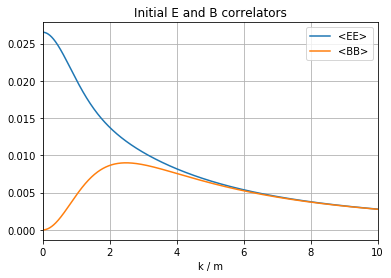

In [6]:
plt.title("Initial E and B correlators")
plt.plot(k_range, cE(k_range), label="<EE>")
plt.plot(k_range, cB(k_range), label="<BB>")
plt.grid()
plt.legend()
plt.xlabel("k / m")
plt.xlim(0, 10)
plt.show()

Since the magnetic correlator has a vanishing zero mode, the anisotropy is more pronounced in the evolving system.